# Predicting Insurance Costs

In this project total medical cost should be predicted using linear regression. The dataset can be found [here](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download) and contains information on individual medical insurance bills. Each bill is associated with demographic and personal characteristics of the person who received it.
These features about the patient should be used to predict the cost.

First the relevant libraries are import and the dataset is read in:

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


`charges` serves as the target variable for the prediction.
In general, information about the different features seems obvious to the author and is not elaborated further. However, it can be observed [here](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=downloa).

## Exploring the Dataset

The dataset consis of `1338` observations and `7` features:

In [2]:
df.shape

(1338, 7)

There are no missing values in the dataset:

In [3]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [4]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


The target variable `charges` is right-skewed indicating there are some outliers in the high range of charges. This can be made clearer by looking at the histogram:

<AxesSubplot:>

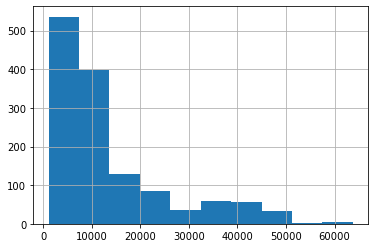

In [5]:
df['charges'].hist()

In [6]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

The dataset consists of numerical and categorical (`sex`, `smoker` and `region`) features. `sex` will be encoded with `male` = `1` and `female`= `0`. `smoker` will be encoded by `1` for `yes` and `0` for `no`:

In [7]:
df['sex'] = df['sex'].map({'male':1,'female':0})
df['smoker'] = df['smoker'].map({'yes':1,'no':0})

The `region` features has to be encoded using dummy variables:

In [8]:
dummies = pd.get_dummies(df['region'])
df = pd.concat([df,dummies],axis=1)
df.drop(labels='region', axis=1, inplace=True)

The *pearson* correlation between the features and the target variable (and also between the features themselves) is given by: 

<AxesSubplot:>

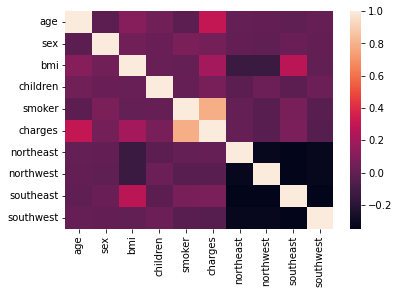

In [9]:
pearsons = df.corr()
plt.figure(figsize=(6,4))
sns.heatmap(pearsons)

A better observability is given by restricting the output to a threshold of `0.15`:

<AxesSubplot:>

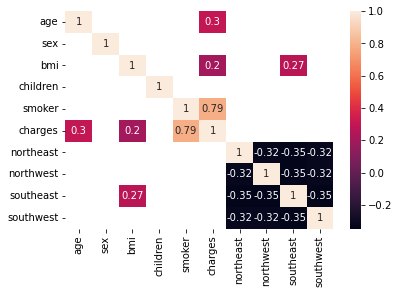

In [10]:
plt.figure(figsize=(6,4))
sns.heatmap(pearsons[abs(pearsons) > 0.15],annot=True)

The target variable `charges` is highly correlated to `smoker` and moderately correlated to `age` and `bmi`.
The `region` dummy variables are (obviously) negatively correlated. `bmi` is correlated with `southeast`.

## Feature Selection and Dividing the Data

Based on the findings above the features `age`, `bmi` and `smoker` will be selected for training the model. For validation also a test subset of this data is necessary. The dividing of the dataset will be performed in the following yielding a test set containing `20%` of the original dataset:

In [11]:
X = df[['age','bmi','smoker']]
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #random_state is selected for reproducibility

## Building the Model

Now the model is built and fitted:

In [12]:
model = LinearRegression()
model.fit(X_train,y_train)

y_pred = model.predict(X_train)

Analysis of the residuals demonstrates a mean of approximately `0`:


In [13]:
residuals = y_train - y_pred
residuals.mean()

4.5729733603162185e-12

However, observing the residuals plot shows strong inconsistencies in variance:

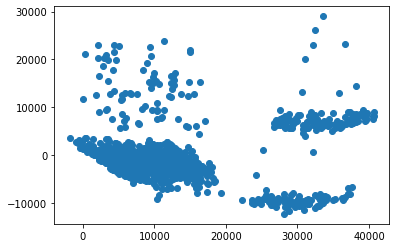

In [14]:
plt.scatter(y_pred, residuals)
plt.show()

The reason behind this might be the distribution of the target variable `charges` as shown above. It is significantly skewed to the right. To counteract this behaviour, the target variable is log-transformed:

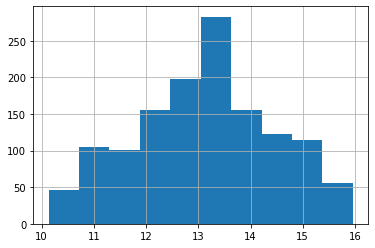

In [15]:
charges_log = np.log2(df['charges'])
charges_log.hist()

y_test_log = np.log2(y_test)
y_train_log = np.log2(y_train)

The log-transformed distribution of `charges` is more centered which makes it more likely that the predictors are unbiased.
Now the model is refitted:

In [16]:
model.fit(X_train,y_train_log)

y_pred = model.predict(X_train)

Analysis of the residuals shows:

In [17]:
residuals = y_train_log - y_pred
residuals.mean()

1.3048752109986887e-15

and:

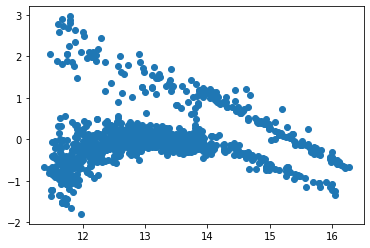

In [18]:
plt.scatter(y_pred, residuals)
plt.show()

The residuals plot still does not show an even band centered around zero. This indicates violations to the assumptions of linear regression. As fitted values get larger, the residuals trend downward. Therefore the model tends to underestimate higher charges and can be described as too conservative.
Nonetheless this model will be used for the rest of the analysis.

The calculated coefficients are on the log-scale and are given on the regular scale by:

In [19]:
np.exp(model.coef_)

array([1.05153746, 1.0162184 , 9.33846476])

It shows that an increase of `1` year of `age` leads to an increase of `5.1 %` in charges (controlling for `bmi` and `smoker`).
The change of the average in `charges` is significant by changing from non-smoker to smoker (controlling for `age` and `bmi`) and raises `charges` by `933 %`.

In [20]:
r2_score(y_train_log, y_pred)

0.737066139753993

The coefficient of determination $R^2$ yields a score of `0.74` indicating that the model can explain 74% of the variation in the log-insurance charges.

The mean squared error yields: 

In [21]:
np.exp(mean_squared_error(y_train_log, y_pred, squared = False))

1.9621898738979213

Again, the exponential is necessary to transform the log-scale to regular scale.

## Model Evaluation and Summary

Finally the model is tested on the test data:

In [22]:
y_pred = model.predict(X_test)
r2_score(y_test_log, y_pred)

0.7704945422014753

In [23]:
np.exp(mean_squared_error(y_test_log, y_pred, squared = False))

1.9258500405115682

In [24]:
residuals = y_test_log - y_pred
residuals.mean()

-0.06706769795368298

The model performs reasonably well on the test subset and shows no sign of overfitting. Keeping the aforementioned limitations in mind (underestimating high values) the model can be useful to predict total medial cost. 